# PINNs: Forward and inverse modeling of Burger's Equation

Exercise: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/burgers-exercise.ipynb)

Solution: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/burgers.ipynb)

## Libraries

In [13]:
#Latin Hypercube Sampling
!pip3 install pyDOE  --quiet
!pip3 install urllib3 --quiet
!pip3 install scipy --quiet

In [14]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import time
from tqdm import tqdm

from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name()}")

Device: cuda


### Tunning Parameters

In [15]:
steps=10000
lr=1e-3
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
# Nu: Number of training points
N_u = 100       #Total number of data points for 'u'
# Nf: Number of collocation points (Evaluate PDE)
N_f = 10000     # Total number of collocation points
nu = 0.01/np.pi # diffusion coeficient

### Auxiliary Functions

In [16]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [17]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [18]:
def solutionplot(u_pred,X_u_train,u_train):
    # https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                extent=[T.min(), T.max(), X.min(), X.max()],
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)

    # Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.75s$', fontsize = 10)

    plt.savefig('Burgers.png',dpi = 500)

# Foward solution to Burgers' Equation

Burgers' equation is a fundamental partial differential equation (PDE) in fluid dynamics and gas dynamics. It combines nonlinear advection and linear diffusion, making it a useful equation for studying the interaction of these two processes.

The one-dimensional, unsteady, viscous Burgers' equation is given by:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

Where:
- $ u = u(x,t) $ is the dependent variable (e.g., velocity in fluid dynamics).
- $ x\in[-1,1] $ is the spatial coordinate.
- $ t\in[0,1] $ is time.
- $ \nu $ is the kinematic viscosity, which determines the strength of the diffusive term. It's a positive constant.

There are two main terms in this equation:
1. **Nonlinear Advection Term**: $ u \frac{\partial u}{\partial x} $ – This term represents the nonlinear convective transport of the quantity $ u $. The nonlinearity arises due to the product $ u \cdot \frac{\partial u}{\partial x} $, which can lead to the formation of shock waves or steep gradients in the solution, especially in the inviscid limit ($ \nu \to 0 $).
  
2. **Diffusion Term**: $ \nu \frac{\partial^2 u}{\partial x^2} $ – This term acts to smooth out sharp gradients or shocks in the solution. For higher values of $ \nu $, diffusion dominates, and the solution will be smoother.

When $ \nu = 0 $, the viscous term drops out, and the equation becomes the inviscid Burgers' equation:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$

This inviscid version is hyperbolic and can develop discontinuities (shocks) from smooth initial conditions.

## PDE

Let:

$u_t=\frac{\partial u}{\partial t}$

$u_x=\frac{\partial u}{\partial x}$

$u_{xx}=\frac{\partial^2 u}{\partial x^2}$

So:

$$u_t+u(u_x)=\nu u_{xx}$$

If we rearrange our PDE, we get:

$$u_t+u(u_x)-\nu u_{xx}=0$$

## Neural Network

A Neural Network is a function:

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

> Note: We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).

## PINNs=Neural Network + PDE
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx u(x,t)$$

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation)

Assume:$$NN(t,x)\approx u(t,x)$$

Then:

$$\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}\approx u_t+u(u_x)-\nu u_{xx}=0$$

And:

$$\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}\approx 0$$


We define this function as $f$:

$$f(t,x)=\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

### Neural Network

In [19]:
class FCN(nn.Module):

    def __init__(self,layers):
        super().__init__()

        self.activation = nn.Tanh()

        self.loss_function = nn.MSELoss(reduction ='mean')

        # Initialise neural network as a list using nn.Modulelist
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0

        # Xavier Normal Initialization
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling

        # convert to float
        a = x.float()

        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)

        return a

    def loss_BC(self,x,y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_PDE(self, X_train_Nf):

        g = X_train_Nf.clone()

        g.requires_grad = True

        u = self.forward(g)

        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nf.shape).to(device), create_graph=True)[0]

        u_x = u_x_t[:,[0]]

        u_t = u_x_t[:,[1]]

        u_xx = u_xx_tt[:,[0]]

        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx

        loss_f = self.loss_function(f,f_hat)

        return loss_f

    def loss(self,x,y,X_train_Nf):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(X_train_Nf)

        loss_val = loss_u + loss_f

        return loss_val

    # test neural network
    def test(self):
        u_pred = self.forward(X_test)
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256,100),order='F')

        return error_vec, u_pred

## Generate data

In [20]:
import urllib.request
import scipy.io
import numpy as np

url = "https://github.com/kks32-courses/sciml/raw/main/docs/01-pinns/Burgers.mat"

# Download the file
response = urllib.request.urlopen(url)
matdata = response.read()
# Write to local file
with open('burgers.mat', 'wb') as f:
  f.write(matdata)

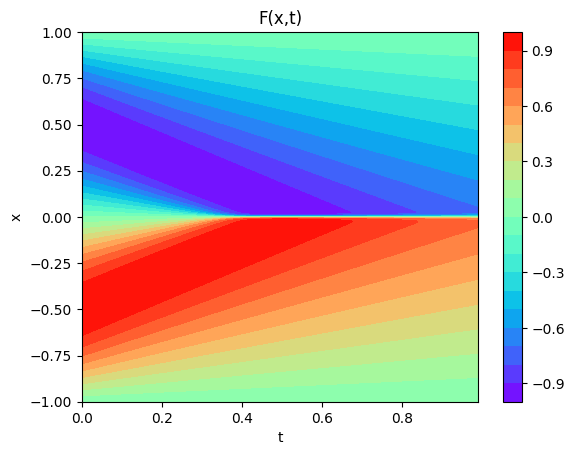

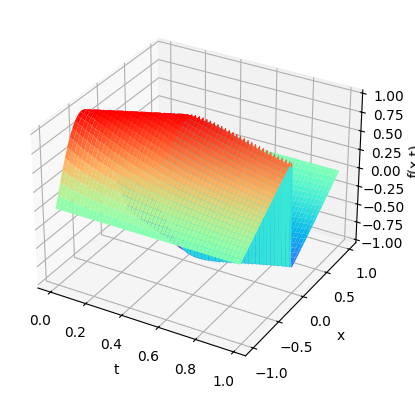

In [21]:
# Load Burger's mat file
data = scipy.io.loadmat('burgers.mat')

x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1]
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))

In [22]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


## Prepare Data

In [23]:
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]
u_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

In [24]:
print(lb, ub)

[-1.  0.] [1.   0.99]


## Training Data

Latin Hypercube Sampling (LHS) is a statistical method designed for generating a near-random sample of parameter values from a multidimensional distribution. The main advantage of LHS over simple random sampling is that it ensures that the entire range of each parameter is adequately sampled. This makes it particularly useful for computer simulations when a multidimensional parameter space needs to be explored.

Here's a basic outline of how Latin Hypercube Sampling works:

1. **Divide Each Dimension**: For each parameter (or dimension) you want to sample, divide the range of the parameter into NN non-overlapping intervals, where NN is the number of samples you desire. These intervals should have an equal probability of being sampled.

1. **Random Sampling Without Replacement**: For each dimension, randomly sample a value from each interval. This ensures that every interval has a sampled value. The key here is that once an interval is sampled, it cannot be sampled again (i.e., no replacement).

1. **Randomize Across Dimensions**: Combine the sampled values from all dimensions to generate a sample point. This process ensures that the sample points are randomly distributed across the entire multidimensional space.

1. **Repeat**: Repeat steps 2 and 3 until you've obtained the desired number of sample points.

Some key properties and advantages of LHS:

1. **Stratification**: By design, LHS guarantees that the entire range of each parameter is sampled. This stratification ensures better space-filling properties than simple random sampling.

1. **Reduction of Clustering**: Since each interval is sampled once and only once, clustering of sample points is reduced, which can be a problem in simple random sampling.

1. **Efficiency**: For many problems, LHS can be more efficient than Monte Carlo sampling, as fewer samples might be needed to achieve the same level of precision.

1. **Flexibility**: While LHS ensures even coverage of the input space, the actual sampled values within each interval are random, which provides flexibility in capturing the underlying distribution.

In many applications, especially in computational experiments where evaluating the model is expensive, Latin Hypercube Sampling provides an efficient and effective way to explore the parameter space. It's widely used in sensitivity analysis, uncertainty analysis, and optimization problems.

In [25]:
# Boundary Conditions

# Initial Condition -1 =< x =<1 and t = 0
left_X = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
left_U = usol[:,0][:,None]

# Boundary Condition x = -1 and 0 =< t =<1
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
bottom_U = usol[-1,:][:,None]

# Boundary Condition x = 1 and 0 =< t =<1
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
top_U = usol[0,:][:,None]

X_train = np.vstack([left_X, bottom_X, top_X])
U_train = np.vstack([left_U, bottom_U, top_U])

# Choose random N_u points for training
idx = np.random.choice(X_train.shape[0], N_u, replace=False)

X_train_Nu = X_train[idx, :]     # choose indices from  set 'idx' (x,t)
U_train_Nu = U_train[idx,:]      # choose corresponding u

# Collocation Points
# Latin Hypercube sampling for collocation points
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb)*lhs(2,N_f)
X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points to collocation points

In [26]:
print("Original shapes for X and U:",X.shape,usol.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,U_train.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and U: (100, 256) (256, 100)
Boundary shapes for the edges: (256, 2) (100, 2) (100, 2)
Available training data: (456, 2) (456, 1)
Final training data: (100, 2) (100, 1)
Total collocation points: (10100, 2)


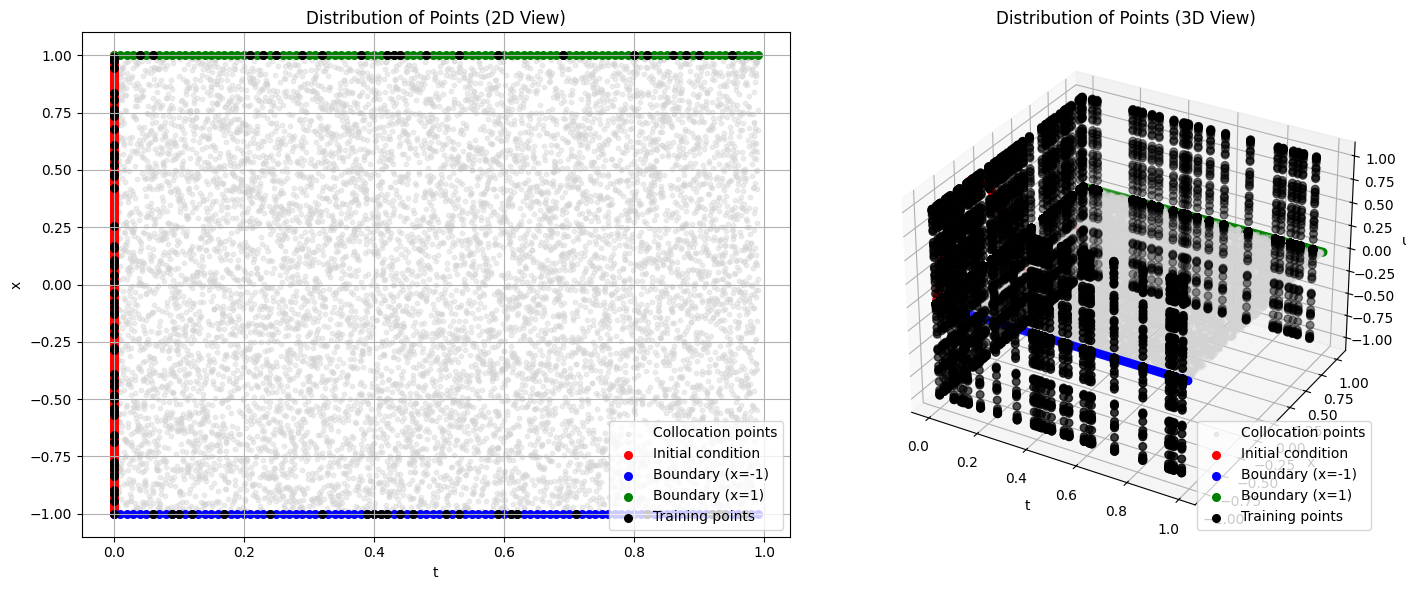

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Separate data into initial, boundary and collocation points
left_X = np.hstack((X[0,:][:,None], T[0,:][:,None]))    # Initial condition points
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None]))  # Lower boundary points
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None]))    # Upper boundary points

# Convert training/collocation points to numpy if they're tensors
if torch.is_tensor(X_train_Nu):
    X_train_Nu = X_train_Nu.cpu().numpy()
if torch.is_tensor(X_train_Nf):
    X_train_Nf = X_train_Nf.cpu().numpy()

# Create figure with 2 subplots side by side
fig = plt.figure(figsize=(15,6))

# 2D Plot
ax1 = fig.add_subplot(121)
ax1.scatter(X_train_Nf[:,1], X_train_Nf[:,0], c='lightgray', alpha=0.4, s=10, label='Collocation points')
ax1.scatter(left_X[:,1], left_X[:,0], c='red', s=30, label='Initial condition')
ax1.scatter(bottom_X[:,1], bottom_X[:,0], c='blue', s=30, label='Boundary (x=-1)')
ax1.scatter(top_X[:,1], top_X[:,0], c='green', s=30, label='Boundary (x=1)')
ax1.scatter(X_train_Nu[:,1], X_train_Nu[:,0], c='black', s=30, label='Training points')

ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Distribution of Points (2D View)')
ax1.legend()
ax1.grid(True)

# 3D Plot with u values
ax2 = fig.add_subplot(122, projection='3d')

# Get u values for boundary points from solution
u_left = usol[:,0]
u_bottom = usol[-1,:]
u_top = usol[0,:]

# Plot collocation points at z=0 since we don't know their u values
ax2.scatter(X_train_Nf[:,1], X_train_Nf[:,0], np.zeros_like(X_train_Nf[:,0]),
           c='lightgray', alpha=0.4, s=10, label='Collocation points')

# Plot boundary points with their u values
ax2.scatter(left_X[:,1], left_X[:,0], u_left, c='red', s=30, label='Initial condition')
ax2.scatter(bottom_X[:,1], bottom_X[:,0], u_bottom, c='blue', s=30, label='Boundary (x=-1)')
ax2.scatter(top_X[:,1], top_X[:,0], u_top, c='green', s=30, label='Boundary (x=1)')

# Get training point u values
if torch.is_tensor(U_train_Nu):
    U_train_Nu = U_train_Nu.cpu().numpy()
ax2.scatter(X_train_Nu[:,1], X_train_Nu[:,0], U_train_Nu, c='black', s=30, label='Training points')

ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_zlabel('u')
ax2.set_title('Distribution of Points (3D View)')
ax2.legend()

plt.tight_layout()
plt.show()

# Train Neural Network

In [28]:
# Convert to tensor and send to GPU
X_train_Nf = torch.from_numpy(X_train_Nf).float().to(device)
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

# Create the model
PINN = FCN(layers)
PINN.to(device)

# Neural Network Summary
print("Neural Network Architecture:")
print(PINN)
print(f"\nTotal trainable parameters: {sum(p.numel() for p in PINN.parameters())}")

# Setup optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr=lr)

# Training with forward pass
print(f"\nStarting training with {steps} epochs...")
print(f"Learning rate: {lr}")
print(f"Device: {device}\n")

start_time = time.time()

# Training loop with tqdm
pbar = tqdm(range(steps), desc="Training PINN")
for epoch in pbar:
    optimizer.zero_grad()

    # Forward pass - compute loss
    loss = PINN.loss(X_train_Nu, U_train_Nu, X_train_Nf)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update progress bar every 100 iterations
    if epoch % 100 == 0:
        error_vec, _ = PINN.test()
        pbar.set_postfix({
            'Loss': f'{loss.item():.4e}',
            'Test Error': f'{error_vec.item():.4f}'
        })

elapsed = time.time() - start_time
print(f'\nTraining completed!')
print(f'Training time: {elapsed:.2f} seconds')

# Model Accuracy
error_vec, u_pred = PINN.test()

print(f'\nFinal Results:')
print(f'  Test Error (Relative L2): {error_vec.item():.5f}')

Neural Network Architecture:
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

Total trainable parameters: 3021

Starting training with 10000 epochs...
Learning rate: 0.001
Device: cuda



Training PINN:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training PINN: 100%|██████████| 10000/10000 [02:27<00:00, 67.79it/s, Loss=5.2419e-04, Test Error=0.0482]


Training completed!
Training time: 147.51 seconds

Final Results:
  Test Error (Relative L2): 0.05673


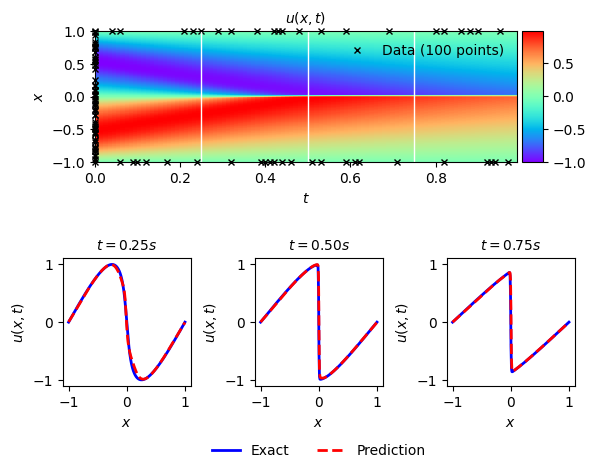

In [29]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

### Plots

In [30]:
x1=X_test[:,0]
t1=X_test[:,1]

In [31]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1=u_pred
arr_y_test=usol

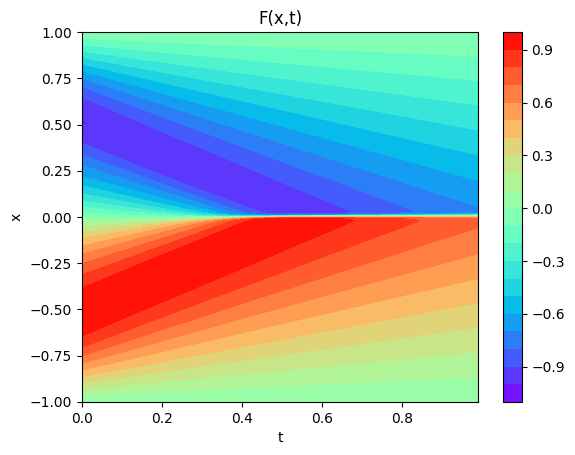

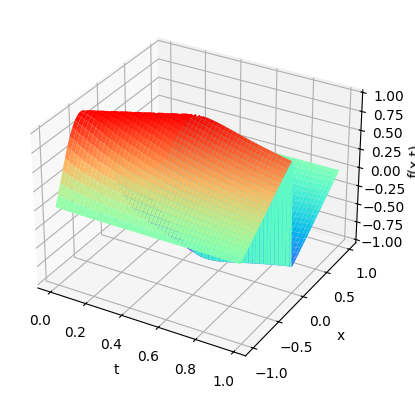

In [32]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(arr_y1))

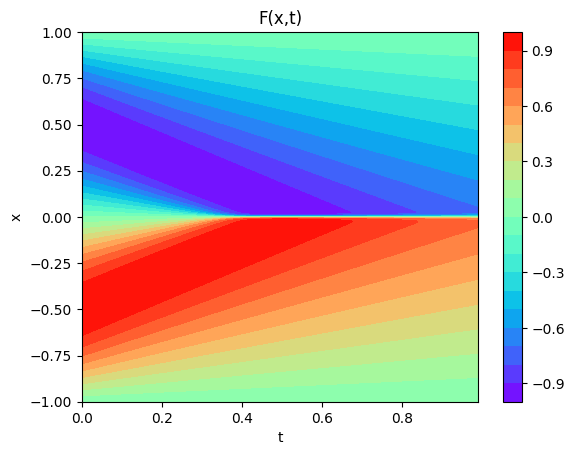

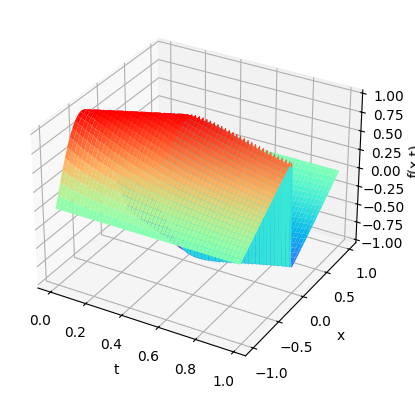

In [33]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))

# Inverse Solution to Burger's Equation

$$\frac{\partial u}{\partial t}+ \lambda_1u\frac{\partial u}{\partial x}=\lambda_2\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

# Inverse Problems

**Forward Problem**: Model $\rightarrow$ Data (Predict)

**Inverse Problem**: Data $\rightarrow$ Model (i.e., actually, we get the Model's parameters)


A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data $\rightarrow$ Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)

# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data $\rightarrow$ Model's parameters so:

Data $\rightarrow$ PINN $\rightarrow$ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$u_t+\mathscr{N}[u;\lambda]=0$$

where, $u(x,t)$ is the hidden solution and $\mathscr{N}[;\lambda]$ is a nonlinear operator parameterized by $\lambda$.

In short: We will use a PINN to get $\lambda$.

Let:

$u_t=\frac{\partial u}{\partial t}$

$u_x=\frac{\partial u}{\partial x}$

$u_{xx}=\frac{\partial^2 u}{\partial x^2}$

$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$

Our PDE is described as:

$$u_t+\lambda_1uu_x=\lambda_2u_{xx}$$

If we rearrange our PDE, we get:

$$u_t+\lambda_1uu_x-\lambda_2 u_{xx}=0$$

Or,

$$u_t+\mathscr{N}[u;\lambda]=0$$

So we can use a PINN to obtain $\lambda$!

In our case (from the reference solution) $\lambda=[\lambda_1,\lambda_2]=[1,\nu]=\left[1,\frac{1}{100\pi}\right]$

## Neural Network

A Neural Network is a function:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

> Note: We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.

## PINNs=Neural Network + PDE
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(x,t)\approx u(x,t)$$

Since N(x,t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(t,x)\approx u(t,x)$$

Then:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx u_t+uu_x-\lambda u_{xx}=0$$

And:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx 0$$


We define this function as $f$:

$$f(t,x)=N_t+\lambda_1NN_x-\lambda_2N_{xx}$$

Remember our operator:

$$f(t,x)=N_t+\mathscr{N}[N,\lambda]$$

So:

$$f(t,x)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($N_u$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_u}\sum^{N_u}_{i=1}|f(t_u^i,x_u^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_u$** (compare it to the reference solution).

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|u(t_{u}^i,x_u^i)-N(t_{u}^i,x_u^i)|^2$$

Please note that $\{t_u^i,x_u^i\}_{i=1}^N$ are the same in $MSE_f$ and $MSE_u$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the ODE parameters (i.e., $\lambda$)$\rightarrow$ We will ask our neural network to find our $\lambda$.

## Neural Network

In [34]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        self.activation = nn.Tanh()

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling

        #convert to float
        a = x.float()

        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        a = self.linears[-1](a)

        return a

## Initialize our parameters

Our operator is:

$$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$$

We know that:

$$\lambda_1=1$$

$$\lambda_2=\nu=\frac{1}{100\pi}=0.003183$$

In [35]:
lambda1=2.0
lambda2=0.2
print("The real λ = [", 1.0, nu, "]. Our initial guess will be λ_PINN = [", lambda1, lambda2, "]")

The real λ = [ 1.0 0.003183098861837907 ]. Our initial guess will be λ_PINN = [ 2.0 0.2 ]


In [36]:
#  PINN
class FCN():
    def __init__(self, layers):
        self.loss_function = nn.MSELoss(reduction ='mean')
        # Initialize iterator
        self.iter = 0
        # Initialize our new parameters i.e. λ (Inverse problem)
        self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)
        self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)
        # Register lambda to optimize
        self.lambda1 = nn.Parameter(self.lambda1)
        self.lambda2 = nn.Parameter(self.lambda2)
        # Call our DNN
        self.dnn = DNN(layers).to(device)
        # Register our new parameter
        self.dnn.register_parameter('lambda1', self.lambda1)
        self.dnn.register_parameter('lambda2', self.lambda2)


    def loss_data(self,x,y):
        loss_u = self.loss_function(self.dnn(x), y)
        return loss_u

    def loss_PDE(self, X_train_Nu):
        lambda1=self.lambda1
        lambda2=self.lambda2

        g = X_train_Nu.clone()
        g.requires_grad = True

        u = self.dnn(g)
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nu.shape).to(device), create_graph=True)[0]
        u_x = u_x_t[:,[0]]
        u_t = u_x_t[:,[1]]
        u_xx = u_xx_tt[:,[0]]

        f = u_t + (lambda1)*(self.dnn(g))*(u_x) - (lambda2)*u_xx
        loss_f = self.loss_function(f,f_hat)

        return loss_f

    def loss(self,x,y):

        loss_u = self.loss_data(x,y)
        loss_f = self.loss_PDE(x)

        loss_val = loss_u + loss_f
        return loss_val

    # test neural network
    def test(self):

        u_pred = self.dnn(X_true)
        error_vec = torch.linalg.norm((U_true-u_pred),2)/torch.linalg.norm(U_true,2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(x.shape[0],t.shape[0]),order='F')

        return error_vec, u_pred

## Visualize the data

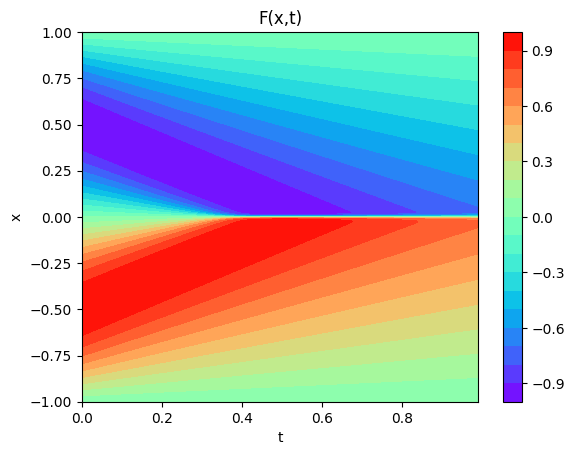

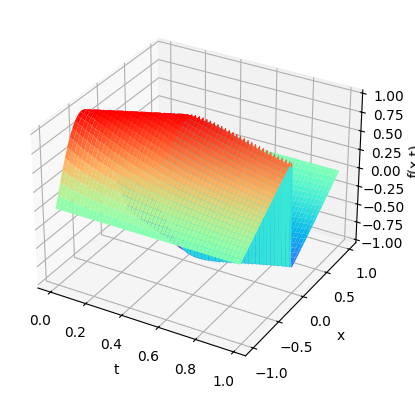

In [37]:
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1]
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))

In [38]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


## Prepare Data

In [39]:
X_true = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_true[0]  # [-1. 0.]
ub = X_true[-1] # [1.  0.99]
U_true = usol.flatten('F')[:,None] # (Column Major)

In [40]:
print(lb,ub)

[-1.  0.] [1.   0.99]


## Training data

In [41]:
total_points=len(x)*len(t)

# Obtain random points for interior
id_f = np.random.choice(total_points, N_f, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_true[id_f]
U_train_Nu= U_true[id_f]

print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")

print("Original shapes for X and U:",X.shape,usol.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)

We have 25600 points. We will select 10000 points to train our model.
Original shapes for X and U: (100, 256) (256, 100)
Final training data: (10000, 2) (10000, 1)


## Train Neural Network

In [42]:
# Convert our arrays to tensors and send them to our GPU
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
U_true = torch.from_numpy(U_true).float().to(device)
f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

In [43]:
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [44]:
PINN = FCN(layers)

# Neural Network Summary
print("Neural Network Architecture:")
print(PINN.dnn)
print(f"\nTotal trainable parameters: {sum(p.numel() for p in PINN.dnn.parameters())}")

params = list(PINN.dnn.parameters())

## Optimization
# Use Adam optimizer instead of L-BFGS for better control
optimizer = torch.optim.Adam(params, lr=lr)

print(f"\nStarting inverse problem training with {steps} epochs...")
print(f"Learning rate: {lr}")
print(f"Initial λ₁ = {PINN.lambda1.item():.4f}, λ₂ = {PINN.lambda2.item():.6f}")
print(f"True λ₁ = 1.0000, λ₂ = {nu:.6f}")
print(f"Device: {device}\n")

start_time = time.time()

# Training loop with tqdm
pbar = tqdm(range(steps), desc="Training Inverse PINN")
for epoch in pbar:
    optimizer.zero_grad()

    # Forward pass - compute loss
    loss = PINN.loss(X_train_Nu, U_train_Nu)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update progress bar every 100 iterations
    if epoch % 100 == 0:
        error_vec, _ = PINN.test()
        pbar.set_postfix({
            'Loss': f'{loss.item():.4e}',
            'Error': f'{error_vec.item():.4f}',
            'λ₁': f'{PINN.lambda1.item():.4f}',
            'λ₂': f'{PINN.lambda2.item():.5f}'
        })

elapsed = time.time() - start_time
print(f'\nTraining completed!')
print(f'Training time: {elapsed:.2f} seconds')

# Model Accuracy
error_vec, u_pred = PINN.test()

print(f'\nFinal Results:')
print(f'  Test Error (Relative L2): {error_vec.item():.5f}')
print(f'  Final λ₁ = {PINN.lambda1.item():.5f} (True: 1.00000)')
print(f'  Final λ₂ = {PINN.lambda2.item():.6f} (True: {nu:.6f})')
print(f'  λ₁ error: {abs(PINN.lambda1.item() - 1.0)/1.0*100:.2f}%')
print(f'  λ₂ error: {abs(PINN.lambda2.item() - nu)/nu*100:.2f}%')

Neural Network Architecture:
DNN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

Total trainable parameters: 3023

Starting inverse problem training with 10000 epochs...
Learning rate: 0.001
Initial λ₁ = 2.0000, λ₂ = 0.200000
True λ₁ = 1.0000, λ₂ = 0.003183
Device: cuda



Training Inverse PINN: 100%|██████████| 10000/10000 [02:30<00:00, 66.35it/s, Loss=8.7028e-04, Error=0.0428, λ₁=0.9316, λ₂=0.00546]


Training completed!
Training time: 150.71 seconds

Final Results:
  Test Error (Relative L2): 0.06855
  Final λ₁ = 0.93030 (True: 1.00000)
  Final λ₂ = 0.005483 (True: 0.003183)
  λ₁ error: 6.97%
  λ₂ error: 72.24%


## Plots

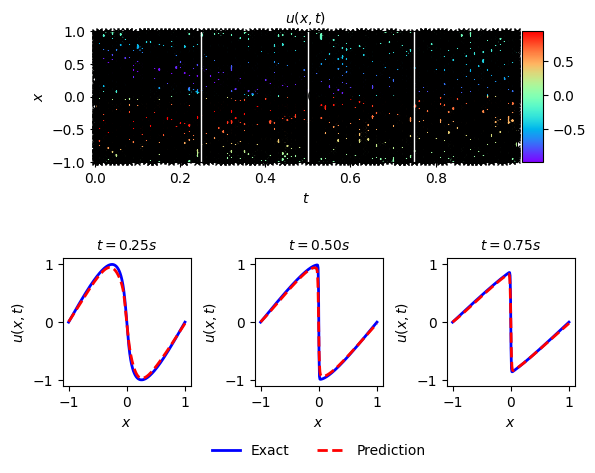

In [45]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

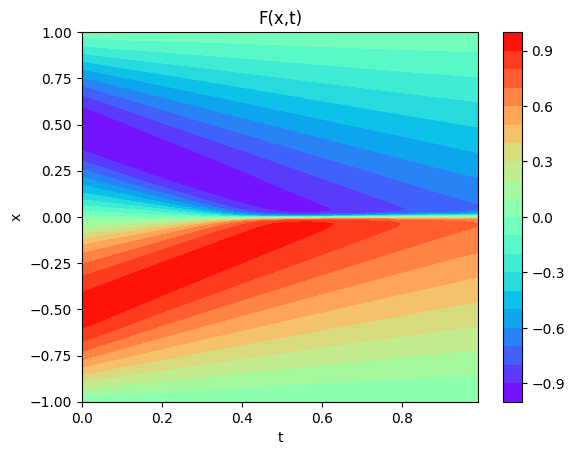

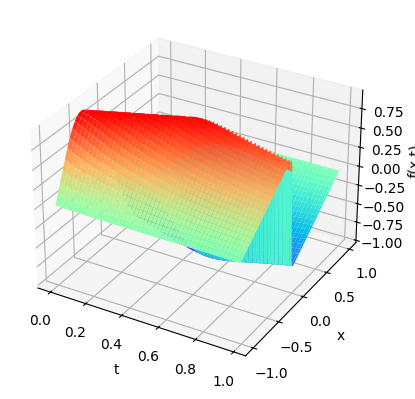

In [46]:
x1=X_true[:,0]
t1=X_true[:,1]
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(u_pred))

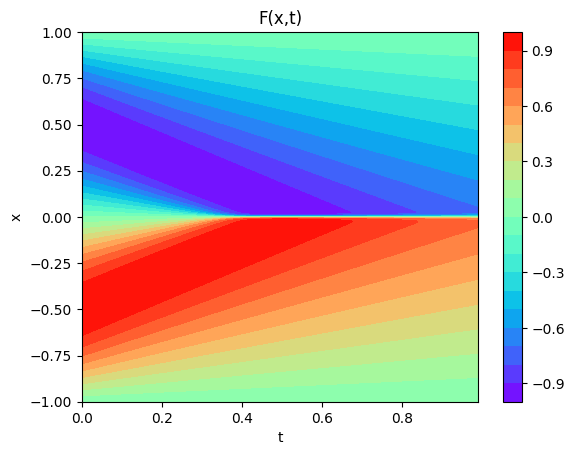

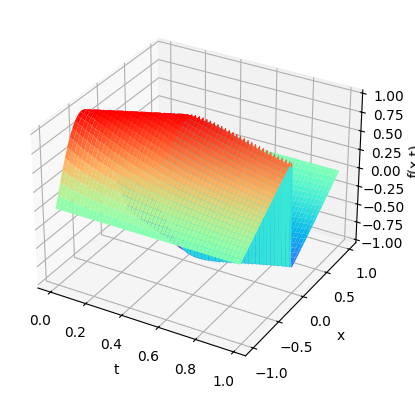

In [47]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))

## References:

[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.